<a href="https://colab.research.google.com/github/Vaibhav-Ahuja1/Mlflow_Bike_Rental/blob/main/Bike_rental_mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github link : https://github.com/alfozan/mlflow-example

Dateset: Bike Sharing Dataset: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

Goal: predict rented_bikes (count per hour) based on weather and time information.



# **DESCRIPTION**

This is an prediction model python notebook. In this ML model we are predicting how many bicycles will be rented at a particualr hour considering various other features like weather , day (Holiday or working day) , season, temp, humidity and some other .

Here we have used GBRT (Gradient Boosted Regression Tree) as our model training algorithm.

Our algorithm has these features :

   Approache: Decision tree (Supervised learning)

   Tree type: Regression tree

   Technique/ensemble method: Gradient boosting

Evaluation Parameters : RMSE , RMSE_CV

Metrics tracking ui : MLFlow

SSH tunneling : Ngrok


In [ ]:
#Installing dependencies
!pip install mlflow --quiet    # Installing without logs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from mlflow.models.signature import infer_signature
from sklearn import tree

from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image

import itertools

plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

# **Import Data**

Input file: hour.csv - contains bike sharing counts aggregated on hourly basis.

Size: 17379 rows which equals to 17379 hours. That signifies we have the data of total 17379 hrs from which we have to predict the rented bikes.

In [ ]:
# download and extract csv files into Data folder
!wget -nc "http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
!unzip -o "Bike-Sharing-Dataset.zip"

File ‘Bike-Sharing-Dataset.zip’ already there; not retrieving.

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [ ]:
bike_sharing=pd.read_csv("hour.csv")
bike_sharing

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
bike_sharing.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


# Data Preprocessing

In [ ]:
# remove unused columns
bike_sharing.drop(columns=["instant", "dteday", "registered", "casual"], inplace=True)

# use better names
bike_sharing.rename(
    columns={
        "yr": "year",
        "mnth": "month",
        "hr": "hour_of_day",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_situation",
        "temp": "temperature",
        "atemp": "feels_like_temperature",
        "hum": "humidity",
        "cnt": "rented_bikes",
    },
    inplace=True,
)

# show samples
bike_sharing

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61


# Visualization

<Axes: title={'center': 'Total rented bikes by hour of day'}, xlabel='hour_of_day'>

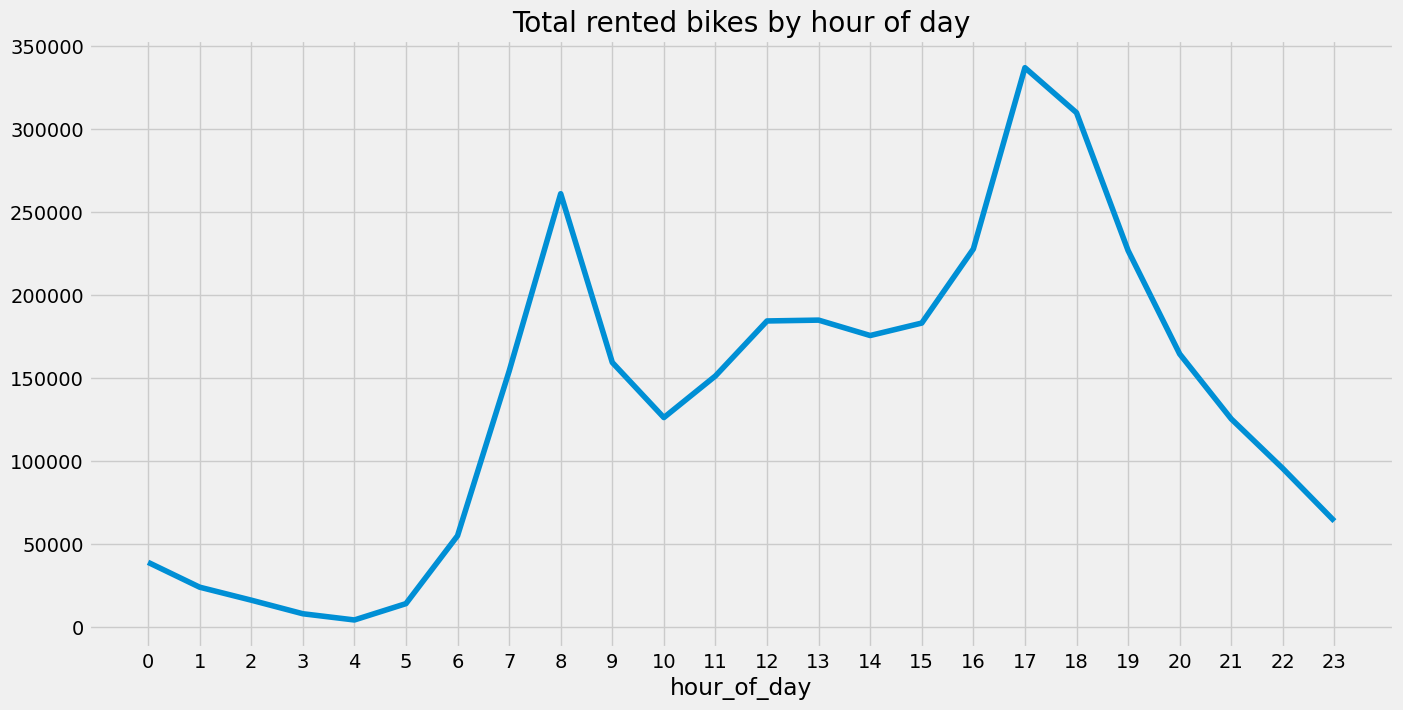

In [ ]:
# We are add all the bikes rented with respect to hours, so at 0 hours a certain 
# no. of bikes got rented and plot that no.of rented bikes on y-axis as count.
hour_of_day_agg = bike_sharing.groupby(["hour_of_day"])["rented_bikes"].sum()

hour_of_day_agg.plot(
    kind="line", 
    title="Total rented bikes by hour of day",
    xticks=hour_of_day_agg.index,
    figsize=(15, 7.5),
)

In [ ]:
hour_of_day_agg

hour_of_day
0      39130
1      24164
2      16352
3       8174
4       4428
5      14261
6      55132
7     154171
8     261001
9     159438
10    126257
11    151320
12    184414
13    184919
14    175652
15    183149
16    227748
17    336860
18    309772
19    226789
20    164550
21    125445
22     95612
23     63941
Name: rented_bikes, dtype: int64

# Prepare training and test data sets

In [ ]:
# Split the dataset randomly into 70% for training and 30% for testing.
X = bike_sharing.drop("rented_bikes", axis=1)
y = bike_sharing.rented_bikes
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.size}")
print(f"Test samples: {X_test.size}")

Training samples: 145980
Test samples: 62568


# Evaluation Metrics

Root Mean Square Error (RMSE)

In [ ]:

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def rmse_score(y, y_pred):
    score = rmse(y, y_pred)
    print("RMSE score: {:.4f}".format(score))
    return score
     

Cross-Validation RMSLE score

In [ ]:
def rmsle_cv(model, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=42).get_n_splits(X_train.values)
    # Evaluate a score by cross-validation
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse


def rmse_cv_score(model, X_train, y_train):
    score = rmsle_cv(model, X_train, y_train)
    print("Cross-Validation RMSE score: {:.4f} (std = {:.4f})".format(score.mean(), score.std()))
    return score

Feature Importance

In [ ]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train.columns,
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')


Permutation Importance

In [ ]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

Decision Tree Visualization

In [ ]:
def model_tree_visualization(model):
    # generate visualization
    tree_dot_data = tree.export_graphviz(
        decision_tree=model.estimators_[0, 0],  # Get the first tree,
        label="all",
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        proportion=True,
        impurity=False,
        precision=1,
    )

    # save image
    graph_from_dot_data(tree_dot_data).write_png("model_artifacts/Decision_Tree_Visualization.png")

    # show tree
    return graphviz.Source(tree_dot_data)

# MLflow Tracking

MLflow Logger

In [ ]:
# Track params and metrics
def log_mlflow_run(model, signature):
    # Auto-logging for scikit-learn estimators
    # mlflow.sklearn.autolog()

    # log estimator_name name
    name = model.__class__.__name__
    mlflow.set_tag("estimator_name", name)

    # log input features
    mlflow.set_tag("features", str(X_train.columns.values.tolist()))

    # Log tracked parameters only
    mlflow.log_params({key: model.get_params()[key] for key in parameters})

    mlflow.log_metrics({
        'RMSE_CV': score_cv.mean(),
        'RMSE': score,
    })

    # log training loss
    for s in model.train_score_:
        mlflow.log_metric("Train Loss", s)

    # Save model to artifacts
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # log charts
    mlflow.log_artifacts("model_artifacts")

    # misc
    # Log all model parameters
    # mlflow.log_params(model.get_params())
    # mlflow.log_param("Training size", X_test.size)
    # mlflow.log_param("Test size", y_test.size)

Initialize MLflow experiment

In [ ]:
experiment_name = "rented_bikes"

mlflow.set_experiment(experiment_name)
mlflow.set_tracking_uri("./mlruns")

# delete default experiment if exits
#if (mlflow.get_experiment_by_name("Default").lifecycle_stage == 'active'):
 #   mlflow.delete_experiment("0")

# create model_artifacts directory 
!mkdir -p "model_artifacts"

Start experiments tracking UI

MLFlow ui url

In [ ]:
!pip uninstall pyngrok -y
!pip install pyngrok==4.1.1
from pyngrok import ngrok
!ngrok authtoken 2KKhRclDAU3bYMXqnKxXJlmqEGr_gSXbmbr5iMfhP34Vjv5W
!ngrok.kill()
from pyngrok import ngrok
public_url = ngrok.connect(port='5000')
print(public_url)

Found existing installation: pyngrok 4.1.1
Uninstalling pyngrok-4.1.1:
  Successfully uninstalled pyngrok-4.1.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyngrok-4.1.1-py3-none-any.whl


Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
/bin/bash: -c: line 1: syntax error: unexpected end of file
http://76fc-104-197-216-230.ngrok.io


In [ ]:
!mlflow ui --host 0.0.0.0 --port 5000

[2023-04-01 13:35:47 +0000] [23183] [INFO] Starting gunicorn 20.1.0
[2023-04-01 13:35:47 +0000] [23183] [INFO] Listening at: http://0.0.0.0:5000 (23183)
[2023-04-01 13:35:47 +0000] [23183] [INFO] Using worker: sync
[2023-04-01 13:35:47 +0000] [23184] [INFO] Booting worker with pid: 23184
[2023-04-01 13:35:48 +0000] [23185] [INFO] Booting worker with pid: 23185
[2023-04-01 13:35:48 +0000] [23186] [INFO] Booting worker with pid: 23186
[2023-04-01 13:35:48 +0000] [23187] [INFO] Booting worker with pid: 23187
[2023-04-01 15:00:16 +0000] [23183] [INFO] Handling signal: int
[2023-04-01 15:00:16 +0000] [23185] [INFO] Worker exiting (pid: 23185)
[2023-04-01 15:00:16 +0000] [23186] [INFO] Worker exiting (pid: 23186)
[2023-04-01 15:00:16 +0000] [23187] [INFO] Worker exiting (pid: 23187)
[2023-04-01 15:00:16 +0000] [23184] [INFO] Worker exiting (pid: 23184)

Aborted!
[2023-04-01 15:00:18 +0000] [23183] [INFO] Shutting down: Master


In [ ]:
!ngrok.kill()

/bin/bash: -c: line 1: syntax error: unexpected end of file


# Model Training

## Model Type & Method

For this example,

Approache: Decision tree (Supervised learning)

Tree type: Regression tree

Technique/ensemble method: Gradient boosting

*All* put together we get: GBRT (Gradient Boosted Regression Tree)

In [ ]:
# GBRT (Gradient Boosted Regression Tree) scikit-learn implementation 
model_class = GradientBoostingRegressor

In [ ]:
#Model Hyperparmeters
parameters = {
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [4, 5, 6],
    # "verbose": True,
}

## Tuning the hyper-parameters: Grid search

In [ ]:
# generate parameters combinations
params_keys = parameters.keys()
params_values = [
    parameters[key] if isinstance(parameters[key], list) else [parameters[key]]
    for key in params_keys
]
runs_parameters = [
    dict(zip(params_keys, combination)) for combination in itertools.product(*params_values)
]

In [ ]:
# Training runs
# training loop
for i, run_parameters in enumerate(runs_parameters):
    print(f"Run {i}: {run_parameters}")

    # mlflow: stop active runs if any
    if mlflow.active_run():
        mlflow.end_run()
    # mlflow:track run
    mlflow.start_run(run_name=f"Run {i}")

    # create model instance
    model = model_class(**run_parameters)

    # train
    model.fit(X_train, y_train)

    # get evaluations scores
    score = rmse_score(y_test, model.predict(X_test))
    score_cv = rmse_cv_score(model, X_train, y_train)
    
    # generate charts
    model_feature_importance(model)
    plt.close()
    model_permutation_importance(model)
    plt.close()
    model_tree_visualization(model)

# get model signature
    signature = infer_signature(model_input=X_train, model_output=model.predict(X_train))

    # mlflow: log metrics
    log_mlflow_run(model, signature)

    # mlflow: end tracking
    mlflow.end_run()
    print("")
     

Run 0: {'learning_rate': 0.1, 'max_depth': 4}
RMSE score: 52.0053
Cross-Validation RMSE score: 56.5457 (std = 0.1486)

Run 1: {'learning_rate': 0.1, 'max_depth': 5}
RMSE score: 44.6971
Cross-Validation RMSE score: 48.1798 (std = 0.1637)

Run 2: {'learning_rate': 0.1, 'max_depth': 6}
RMSE score: 41.8812
Cross-Validation RMSE score: 45.0010 (std = 0.4139)

Run 3: {'learning_rate': 0.05, 'max_depth': 4}
RMSE score: 63.1562
Cross-Validation RMSE score: 67.8207 (std = 1.7228)

Run 4: {'learning_rate': 0.05, 'max_depth': 5}
RMSE score: 53.0556
Cross-Validation RMSE score: 55.9777 (std = 0.8674)

Run 5: {'learning_rate': 0.05, 'max_depth': 6}
RMSE score: 46.2965
Cross-Validation RMSE score: 49.8103 (std = 0.5304)

Run 6: {'learning_rate': 0.01, 'max_depth': 4}
RMSE score: 120.1656
Cross-Validation RMSE score: 123.9446 (std = 1.0540)

Run 7: {'learning_rate': 0.01, 'max_depth': 5}
RMSE score: 112.4922
Cross-Validation RMSE score: 116.0879 (std = 0.9958)

Run 8: {'learning_rate': 0.01, 'max_dep

We got 9 runs because of 3 learning rate and 3 depth,so the no. of generated combinations will be 9 

# Best Model Results

In [ ]:
best_run_df = mlflow.search_runs(order_by=['metrics.RMSE_CV ASC'], max_results=1)
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.sklearn.load_model(best_model_uri)


In [ ]:
# print best run info
print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: RMSE_CV = {:.4f}".format(best_run.data.metrics['RMSE_CV']))
print(f"Run model URI: {best_model_uri}")
     

Best run info:
Run id: 46c8c2644bc24a38b71caa3301d6df82
Run parameters: {'learning_rate': '0.1', 'max_depth': '6'}
Run score: RMSE_CV = 45.0010
Run model URI: file:///content/mlruns/383973996479576520/46c8c2644bc24a38b71caa3301d6df82/artifacts/model


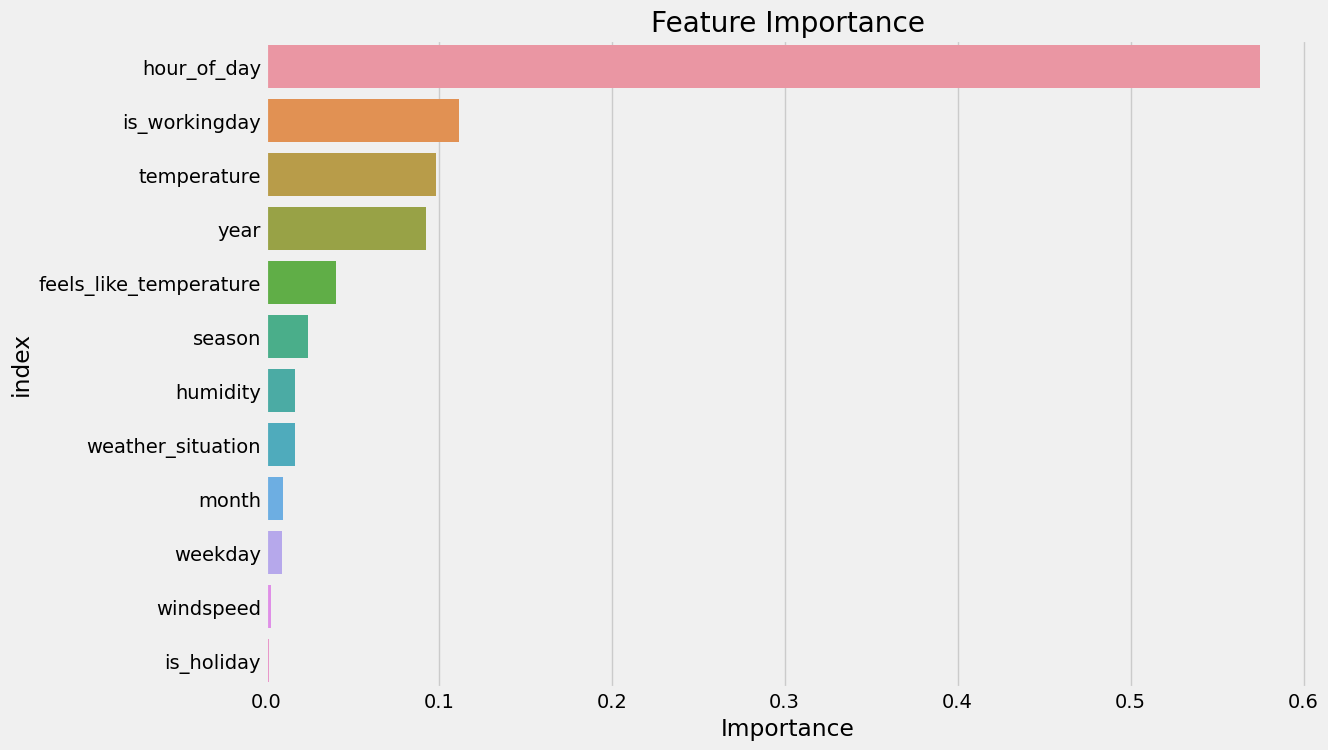

In [ ]:
model_feature_importance(best_model)

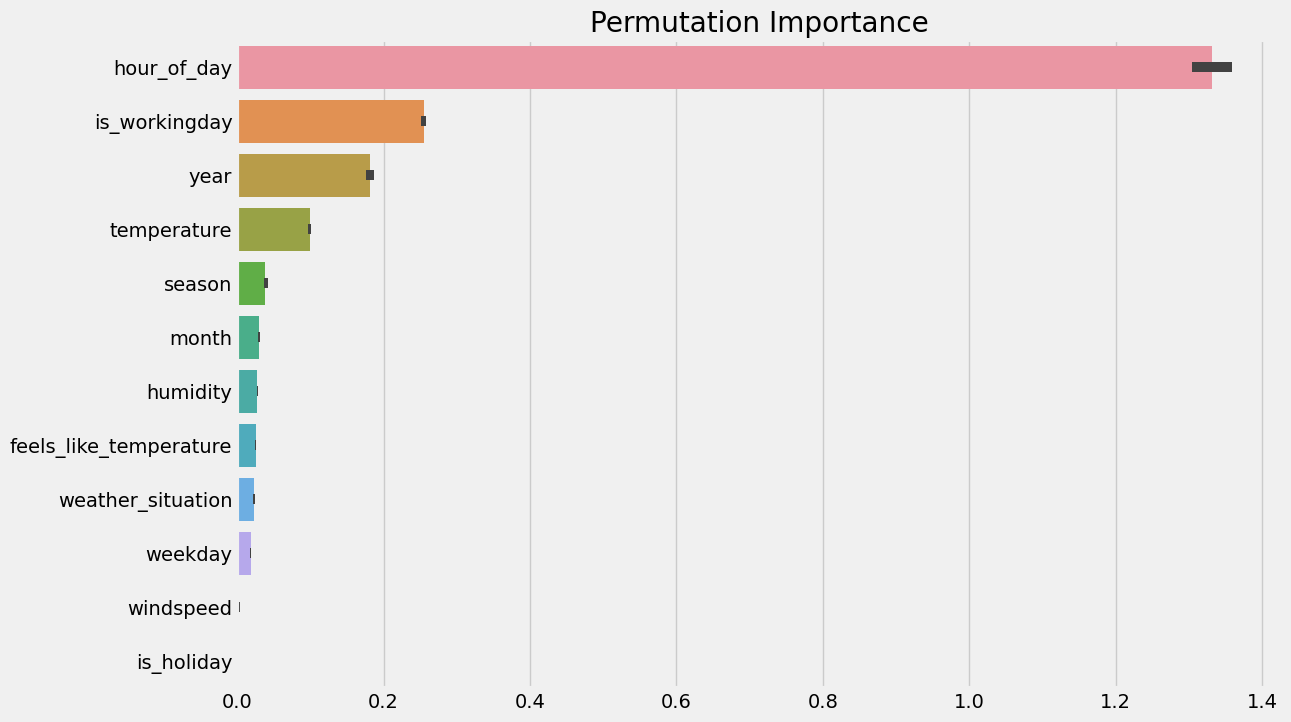

In [ ]:
model_permutation_importance(best_model)

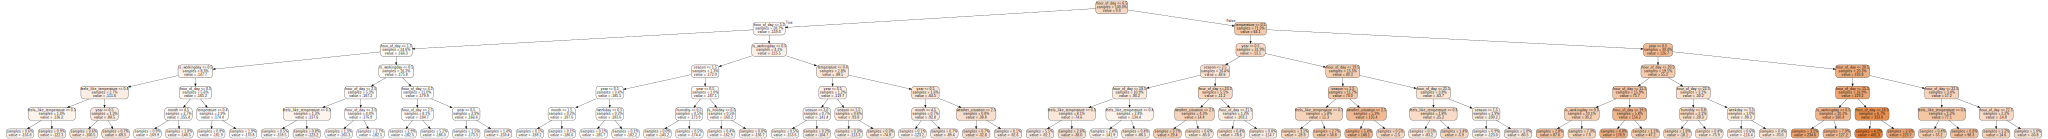

In [ ]:
model_tree_visualization(best_model)

# Inference

In [ ]:

test_predictions = X_test.copy()
# real output (rented_bikes) from test dataset
test_predictions["rented_bikes"] = y_test

# add "predicted_rented_bikes" from test dataset
test_predictions["predicted_rented_bikes"] = best_model.predict(X_test).astype(int)

# show results
test_predictions
     

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes,predicted_rented_bikes
12830,3,1,6,19,0,6,0,1,0.80,0.6970,0.27,0.1940,425,397
8688,1,1,1,20,1,1,0,1,0.24,0.2273,0.41,0.2239,88,99
7091,4,0,10,2,0,5,1,1,0.32,0.3030,0.66,0.2836,4,13
12230,2,1,5,19,0,2,1,1,0.78,0.7121,0.52,0.3582,526,564
431,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881,13,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12749,2,1,6,10,0,3,1,1,0.82,0.7727,0.52,0.1343,167,182
11476,2,1,4,9,0,6,0,2,0.38,0.3939,0.37,0.0000,214,241
12847,3,1,6,12,0,0,0,1,0.80,0.6970,0.33,0.2239,556,555
16721,4,1,12,12,0,2,1,1,0.52,0.5000,0.68,0.1940,312,297
